In [1]:
import pandas as pd
import sys
from pathlib import Path
base_dir = str(Path(Path.cwd()).resolve().parent.parent)
print(base_dir)
sys.path.append(base_dir)

B:\data_science_projects\erdos_institute\aware-nlp


In [2]:
from src.retriever import CustomRetriever, QdrantRetriever, ChromaRetriever, BaseRetriever

c:\Users\Peter\AppData\Local\Continuum\anaconda3\envs\reddit-rag\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Sample Dataset

##### load dataset

In [3]:
sample_file = '../../data/best_buy/questions_statements_labels.csv'
df = pd.read_csv(sample_file).drop(columns=['Unnamed: 0'])
df

,statement,question,label_sum,average_label,consensus,reddit_id,aware_post_type,aware_created_ts,reddit_link_id,reddit_parent_id,reddit_permalink,reddit_subreddit
0,![gif](giphy|znRstrOYuirrW),What do Best Buy employees think of the company?,0.0,0.000000,0,ju59a0l,comment,2023-07-30T21:11:35,t3_15e1vvl,t3_15e1vvl,/r/BestBuyWorkers/comments/15e1vvl/customer_po...,BestBuyWorkers
1,#shockedpikachuface,What do Best Buy employees think of the company?,0.0,0.000000,0,hhgbgps,comment,2021-10-21T00:06:32,t3_qafhhx,t1_hh3zf24,/r/BestBuyWorkers/comments/qafhhx/we_can_impro...,BestBuyWorkers
2,12 hr shift here too. Normal pay man,What are the most common reasons for employees...,2.0,0.285714,1,iwshpu5,comment,2022-11-17T19:35:11,t3_yy085z,t3_yy085z,/r/BestBuyWorkers/comments/yy085z/black_friday...,BestBuyWorkers
3,12-day Application Review; What is the usual d...,What are the most common reasons for employees...,0.0,0.000000,0,klk0z1,submission,2020-12-28T00:22:54,NaN,NaN,/r/BestBuyWorkers/comments/klk0z1/12day_applic...,BestBuyWorkers
4,Absolutely. I had a talk with a leader last we...,Do employees feel understaffed?,7.0,1.000000,1,ibg921p,comment,2022-06-07T00:11:03,t3_v5thte,t1_ibd38u3,/r/BestBuyWorkers/comments/v5thte/what_are_som...,BestBuyWorkers
...,...,...,...,...,...,...,...,...,...,...,...,...
85,done company wide every March not on your work...,What do Best Buy employees think of the company?,0.0,0.000000,0,k01yx5z,comment,2023-09-10T21:51:15,t3_16fik5c,t3_16fik5c,/r/BestBuyWorkers/comments/16fik5c/so_are_annu...,BestBuyWorkers
86,i take only cash tips from anyone thats not a ...,Do employees feel understaffed?,0.0,0.000000,0,ki7m0f4,comment,2024-01-16T19:53:41,t3_198a0ow,t3_198a0ow,/r/BestBuyWorkers/comments/198a0ow/customer_ti...,BestBuyWorkers
87,"i've been here for 8 years, work in the highes...",What are the most common reasons for employees...,7.0,1.000000,1,jag8nz0,comment,2023-03-01T00:13:02,t3_11dxaol,t3_11dxaol,/r/BestBuyWorkers/comments/11dxaol/new_to_this...,BestBuyWorkers
88,nah,What do Best Buy employees think of the company?,0.0,0.000000,0,ixd7txp,comment,2022-11-22T10:51:56,t3_z1mzn6,t3_z1mzn6,/r/BestBuyWorkers/comments/z1mzn6/bf_walk_out/...,BestBuyWorkers


#### Plot distribution of average human labels for each question

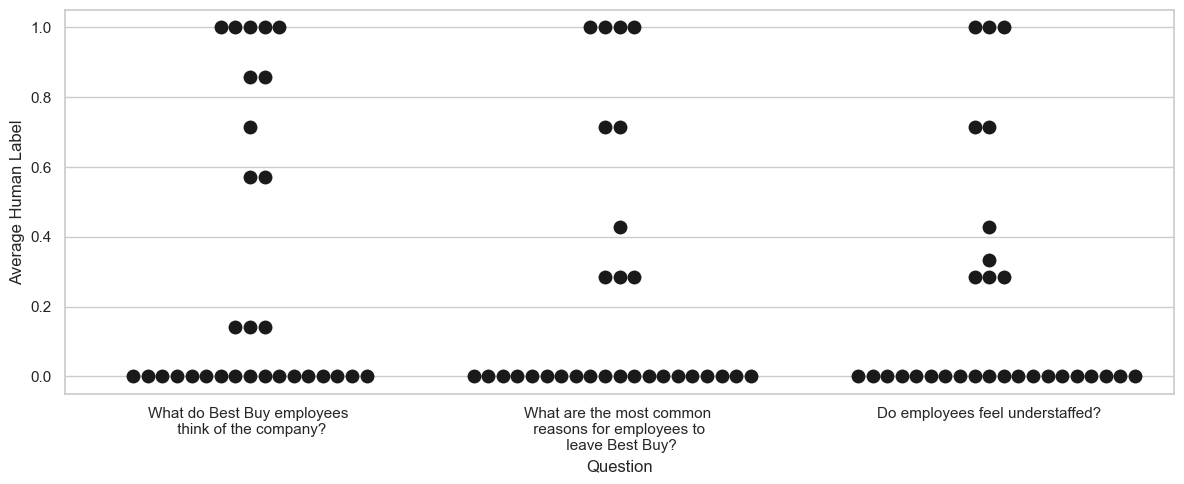

In [173]:
import seaborn as sns

def wrap_text(text, n_words = 5):
    sent = text.split(' ')
    for i in range(n_words, len(sent), n_words):
        sent.insert(i, '\n')
    return ' '.join(sent)
temp_df = df.copy()
temp_df['Question'] = temp_df['question'].apply(wrap_text)
label_colors = {1: 'royalblue', 0: 'firebrick'}

f = plt.figure(figsize=(12,5))
sns.swarmplot(
    x = 'Question', 
    y = 'average_label', 
    data = temp_df.rename(columns = {'relevant':'LLM Label'}),  
    legend = "auto", 
    #palette=label_colors,
    edgecolor='black',
    color='k',
    s=10,
    )
plt.ylabel('Average Human Label')
#plt.axhline(y=2/7, color='black', linestyle='--')
f.tight_layout()
f.savefig('../../figures/bestbuy_human_labels.png')

#### Load sample data into a dictionary where each key corresponds to a list of langchain documents for a particular question

In [174]:
from langchain_community.document_loaders import DataFrameLoader
import numpy as np

def parse_dataset(dataset_df: pd.DataFrame, question: str):
    df = dataset_df[dataset_df.question==question].replace({np.nan: ''})
    loader = DataFrameLoader(df, page_content_column='statement')
    return loader.load()

dataset_df = df.copy().drop(columns = ['label_sum', 'average_label', 'consensus'])
questions = dataset_df.question.unique()
dataset_dict = {f'question_{i}':parse_dataset(dataset_df, q) for i, q in enumerate(questions)}

#### Example of the list of dictionaries for the second question:
'What are the most common reasons for employees to leave Best Buy?'

In [5]:
dataset_dict['question_1']

[Document(page_content='12 hr shift here too. Normal pay man', metadata={'question': 'What are the most common reasons for employees to leave Best Buy?', 'reddit_id': 'iwshpu5', 'aware_post_type': 'comment', 'aware_created_ts': '2022-11-17T19:35:11', 'reddit_link_id': 't3_yy085z', 'reddit_parent_id': 't3_yy085z', 'reddit_permalink': '/r/BestBuyWorkers/comments/yy085z/black_friday/iwshpu5/', 'reddit_subreddit': 'BestBuyWorkers'}),
 Document(page_content='12-day Application Review; What is the usual duration to receive a response for an application? I submitted one on Dec 15 and it is still under review. Is this unusual or do they take a long time to review?', metadata={'question': 'What are the most common reasons for employees to leave Best Buy?', 'reddit_id': 'klk0z1', 'aware_post_type': 'submission', 'aware_created_ts': '2020-12-28T00:22:54', 'reddit_link_id': '', 'reddit_parent_id': '', 'reddit_permalink': '/r/BestBuyWorkers/comments/klk0z1/12day_application_review/', 'reddit_subred

## Retriever example Calls


#### Each of the next few subsections runs retrieval on the list of documents corresponding to question 0: 
 'What do Best Buy employees think of the company?'
#### Each is a different implementation/pipeline derived from the <code>BaseRetriever</code> class. These classes are called with the following methods:
1. class object construction with required arguments:
    - documents: List[Document]
    - embedding_model: str
    - similarity_metric: Literal['cosine-similarity','dot', 'euclidian']
2. load_documents()
    - This instantiates the in-memory database, computes embeddings, and loads them into the database
3. retrieve(query, n=n_docs)
    - Retrieves the n_docs documents with the best similarity scores in accordance to the metric provided at object construction

In [175]:
docs = dataset_dict['question_0']
print(docs[0])

page_content='![gif](giphy|znRstrOYuirrW)' metadata={'question': 'What do Best Buy employees think of the company?', 'reddit_id': 'ju59a0l', 'aware_post_type': 'comment', 'aware_created_ts': '2023-07-30T21:11:35', 'reddit_link_id': 't3_15e1vvl', 'reddit_parent_id': 't3_15e1vvl', 'reddit_permalink': '/r/BestBuyWorkers/comments/15e1vvl/customer_posts_are_disallowed_on_this_subreddit/ju59a0l/', 'reddit_subreddit': 'BestBuyWorkers'}


### Custom Retriever Example

In [7]:

encoder_name = 'multi-qa-mpnet-base-dot-v1'
retr = CustomRetriever(docs, encoder_name, 'cosine-similarity')

In [8]:
retr.load_documents()

In [9]:
output = retr.retrieve(docs[0].metadata['question'])
output

c:\Users\Peter\AppData\Local\Continuum\anaconda3\envs\reddit-rag\Lib\site-packages\sentence_transformers\util.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  b = torch.tensor(b)


[{'document': Document(page_content='Don’t listen to this guy, I work there and the team environment is outstanding everyone stands around talking to each other and let’s the antisocial people ring up the customers. You’ll enjoy Best Buy as long as you aren’t antisocial and you actually enjoy technology', metadata={'question': 'What do Best Buy employees think of the company?', 'reddit_id': 'iw9vtz5', 'aware_post_type': 'comment', 'aware_created_ts': '2022-11-13T20:26:31', 'reddit_link_id': 't3_yuacvb', 'reddit_parent_id': 't1_iw8gy71', 'reddit_permalink': '/r/BestBuyWorkers/comments/yuacvb/looking_to_get_a_job/iw9vtz5/', 'reddit_subreddit': 'BestBuyWorkers'}),
  'score': 0.74243915},
 {'document': Document(page_content='Life as a Best Buy worker 💀', metadata={'question': 'What do Best Buy employees think of the company?', 'reddit_id': '134bzme', 'aware_post_type': 'submission', 'aware_created_ts': '2023-04-30T23:58:58', 'reddit_link_id': '', 'reddit_parent_id': '', 'reddit_permalink':

#### Qdrant Implementation

In [10]:
retr_qdrant = QdrantRetriever(docs, encoder_name, 'euclidian')
retr_qdrant.load_documents()

In [11]:
output = retr_qdrant.retrieve(docs[0].metadata['question'])
output

[{'document': Document(page_content='Life as a Best Buy worker 💀', metadata={'question': 'What do Best Buy employees think of the company?', 'reddit_id': '134bzme', 'aware_post_type': 'submission', 'aware_created_ts': '2023-04-30T23:58:58', 'reddit_link_id': '', 'reddit_parent_id': '', 'reddit_permalink': '/r/BestBuyWorkers/comments/134bzme/life_as_a_best_buy_worker/', 'reddit_subreddit': 'BestBuyWorkers'}),
  'score': 4.117746998627767},
 {'document': Document(page_content='Don’t listen to this guy, I work there and the team environment is outstanding everyone stands around talking to each other and let’s the antisocial people ring up the customers. You’ll enjoy Best Buy as long as you aren’t antisocial and you actually enjoy technology', metadata={'question': 'What do Best Buy employees think of the company?', 'reddit_id': 'iw9vtz5', 'aware_post_type': 'comment', 'aware_created_ts': '2022-11-13T20:26:31', 'reddit_link_id': 't3_yuacvb', 'reddit_parent_id': 't1_iw8gy71', 'reddit_permal

#### Chroma

In [12]:
retr_chroma = ChromaRetriever(docs, encoder_name, 'euclidian')

In [13]:
retr_chroma.load_documents()

In [14]:
output = retr_qdrant.retrieve(docs[0].metadata['question'])
output

[{'document': Document(page_content='Life as a Best Buy worker 💀', metadata={'question': 'What do Best Buy employees think of the company?', 'reddit_id': '134bzme', 'aware_post_type': 'submission', 'aware_created_ts': '2023-04-30T23:58:58', 'reddit_link_id': '', 'reddit_parent_id': '', 'reddit_permalink': '/r/BestBuyWorkers/comments/134bzme/life_as_a_best_buy_worker/', 'reddit_subreddit': 'BestBuyWorkers'}),
  'score': 4.117746998627767},
 {'document': Document(page_content='Don’t listen to this guy, I work there and the team environment is outstanding everyone stands around talking to each other and let’s the antisocial people ring up the customers. You’ll enjoy Best Buy as long as you aren’t antisocial and you actually enjoy technology', metadata={'question': 'What do Best Buy employees think of the company?', 'reddit_id': 'iw9vtz5', 'aware_post_type': 'comment', 'aware_created_ts': '2022-11-13T20:26:31', 'reddit_link_id': 't3_yuacvb', 'reddit_parent_id': 't1_iw8gy71', 'reddit_permal

## RetrieverEvaluator

#### Definition of RetrieverEvaluator Class
##### Construction Arguments:
1. retriever_name: Defines the pipeline that will be utilized. One of the following:
    - 'chroma' : evaluates on ChromaRetriever class object
    - 'qdrant' : evaluates on QdrantRetriever class object
    - 'custom' : evaluates on CustomRetriever class object
2. encoder_name: embedding model to be used. Makes use of models found at:
    - [SBERT](https://www.sbert.net/docs/pretrained_models.html)
    - [HuggingFace](https://huggingface.co/spaces/mteb/leaderboard)
3. similarity_metric: similarity metric used to rank closest documents to the query in the embedding space. One of the following:
    - 'cosine-similarity'
    - 'dot-product'
    - 'euclidian'
    - 'manhattan' (only available for qdrant retriever)
4. sample_df: Dataframe that documents were sourced from. Required to have the following columns to work:
    - 'question' : query for which we are assessing the quality of retrieval
    - 'statement' : statements that will be formatted as documents and filled into a database
    - 'average_label' : the fraction of human labelers who have labeled the statement as relevant to the question
    - 'label_sum' : the total number of human labelers who have labeled the statement as relevant to the question
5. retrieved_doc_size: The number of documents to be retrieved from which evaluation scores will be calculated
6. consensus_threshold: The minimum number of 'label_sum' for which a document is considered 

##### Calling method: evaluate()
1. Actions:
    - Defines the consensus label based on the consensus_threshold
    - Constructs the retriever class object
    - Loads documents
    - Calculates f1, precision, and recall scores of the retrieval
2. Outputs: A dataframe containing the following columns:
    - 'question': question for which the retrieval quality was evaluated 
    - 'retriever': name of retriever pipeline 
    - 'encoder': name of embedding model
    - 'similarity': name of similarity metric used,
    - 'consensus_threshold': The minimum number of human labelers for which a document is considered ,
    - 'retrieval_size': Number of documents retrieved per question
    - 'total_true_labels': Total number of true labels in the set of documents for the given question as defined by the consensus threshold
    - 'f1': calculated f1 score for the given question
    - 'recall': calculated recall score for the given question
    - 'precision': calculated precision score for the given question

In [35]:
from src.retriever import BaseRetriever
from typing import Literal, List, Dict, Any
from langchain_core.documents import Document
from sklearn.metrics import recall_score, f1_score, precision_score
from langchain_community.document_loaders import DataFrameLoader
import numpy as np

class RetrieverEvaluator:
    def __init__(
            self, 
            retriever_name: Literal['chroma', 'qdrant', 'custom'], 
            encoder_name: str,
            similarity_metric: str,
            sample_df: pd.DataFrame, 
            retrieved_doc_size: int = 10,
            consensus_threshold: int = 2
        ):
        self.retriever_name = retriever_name
        self.consensus_threshold = consensus_threshold
        self.sample_df = sample_df
        self.set_consensus()
        self.similarity_name = similarity_metric
        self.encoder_name = encoder_name
        self.n_retrieved = retrieved_doc_size
        self.questions = sample_df.question.unique()
        self.dataset_dict = self.parse_dataset()

    def set_consensus(self):
        self.sample_df['consensus'] = (self.sample_df['label_sum'] >= self.consensus_threshold).astype(int)

    def get_retriever(self, docs: List[Document]) -> BaseRetriever:
        match self.retriever_name:
            case 'chroma':
                return ChromaRetriever(docs, self.encoder_name, self.similarity_name)
            case 'qdrant':
                return QdrantRetriever(docs, self.encoder_name, self.similarity_name)
            case 'custom':
                return CustomRetriever(docs, self.encoder_name, self.similarity_name)
            case _:
                raise ValueError(f"Retriever {self.retriever_name} not supported")

    def _parse_dataset_one_question(self, question: str):
        df = self.sample_df.drop(columns = ['label_sum', 'average_label', 'consensus']).copy()
        df = df[dataset_df.question==question].fillna('')
        loader = DataFrameLoader(df, page_content_column='statement')
        return loader.load()
        
    def parse_dataset(self):
        return {
            q:self._parse_dataset_one_question(q) 
            for q in self.questions
        }

    def retrieve_one_question(self, question: str):
        retriever = self.get_retriever(self.dataset_dict[question])
        retriever.load_documents()
        retrieved_docs = retriever.retrieve(question, n = self.n_retrieved)
        return retrieved_docs
    
    def _parse_retriever_element(self, elem: Dict[str, Any]):
        return {'statement':elem['document'].page_content, 'score':elem['score']} | elem['document'].metadata

    def _construct_evaluation_df(self, question: str, output: List[Dict[str, Any]]) -> pd.DataFrame:
        df_pred = pd.DataFrame([self._parse_retriever_element(elem) for elem in output])
        df_pred['retrieved'] = 1
        return df[df.question==question].merge(df_pred, how='outer').fillna({'retrieved':0, 'consensus':0})

    def evaluate_one_question(self, question: str):
        retrieved_docs = self.retrieve_one_question(question)
        eval_df = self._construct_evaluation_df(question, retrieved_docs)

        f1 = f1_score(eval_df['consensus'], eval_df['retrieved'])
        recall = recall_score(eval_df['consensus'], eval_df['retrieved'])
        precision = precision_score(eval_df['consensus'], eval_df['retrieved'])
        
        return {
            'question':question, 
            'retriever':self.retriever_name, 
            'encoder':self.encoder_name,
            'similarity':self.similarity_name,
            'consensus_threshold':self.consensus_threshold,
            'retrieval_size': self.n_retrieved,
            'total_true_labels': eval_df['consensus'].sum(),
            'f1':f1, 
            'recall':recall, 
            'precision':precision
        }

    def evaluate(self):
        return pd.DataFrame([self.evaluate_one_question(q) for q in self.questions])
            

#### Single Evaluation

In [149]:
import time

# Parameter assignment
pipeline_name = 'custom'
encoder_name = 'all-mpnet-base-v2'
similarity_metric = 'cosine'
n_retrieved = 10 # Number of documents to retrieve
consensus_threshold = 4 # How many individuals should have labeled the statement as true for it to be considered true as consensus

# Run evaluation
retr_evaluator = RetrieverEvaluator(
    pipeline_name, 
    encoder_name, 
    similarity_metric, 
    df, 
    retrieved_doc_size=n_retrieved, 
    consensus_threshold=consensus_threshold
)
print(f'Running evaluation for {encoder_name} with parameters:\n\tmetric: {similarity_metric}')
print(f'\tretrieval size: {n_retrieved}\n\tconsensus threshold: {consensus_threshold}')
t0 = time.time()
output = retr_evaluator.evaluate()
t1 = time.time()
print(f'...done; took {t1-t0} seconds')

display(output)

Running evaluation for all-mpnet-base-v2 with parameters:
	metric: cosine
	retrieval size: 10
	consensus threshold: 4
...done; took 15.72772479057312 seconds


,question,retriever,encoder,similarity,consensus_threshold,retrieval_size,total_true_labels,f1,recall,precision
0,What do Best Buy employees think of the company?,custom,all-mpnet-base-v2,cosine,4,10,10.0,0.700000,0.700000,0.7
1,What are the most common reasons for employees...,custom,all-mpnet-base-v2,cosine,4,10,6.0,0.500000,0.666667,0.4
2,Do employees feel understaffed?,custom,all-mpnet-base-v2,cosine,4,10,5.0,0.533333,0.800000,0.4


#### Evaluate over range of parameters

In [36]:
import time
encoder_metric_dict = {
    'multi-qa-mpnet-base-dot-v1': ['dot'],
    'multi-qa-mpnet-base-cos-v1': ['euclidian', 'cosine', 'dot'],
    'all-mpnet-base-v2': ['euclidian', 'cosine', 'dot'],
    'gtr-t5-xl': ['euclidian', 'cosine', 'dot'],
    'gtr-t5-xxl': ['euclidian', 'cosine', 'dot'],
    'gtr-t5-large': ['euclidian', 'cosine', 'dot'],
    'all-mpnet-base-v1': ['euclidian', 'cosine', 'dot'],
    'multi-qa-distilbert-cos-v1': ['euclidean', 'cosine', 'dot'],
    'multi-qa-MiniLM-L6-cos-v1': ['euclidean', 'cosine', 'dot'],
}
consensus_thresholds = [2, 4]
n_docs = [5, 10]

encoders = [
    'multi-qa-mpnet-base-cos-v1',
    'all-mpnet-base-v2',
    'gtr-t5-xl',
    'multi-qa-distilbert-cos-v1'
]

output_df = pd.DataFrame()

for encoder_name in encoders:
    for similarity_metric in encoder_metric_dict[encoder_name]:
        for n_retrieved in n_docs:
            for consensus_threshold in consensus_thresholds:
                retr_evaluator = RetrieverEvaluator(
                    'custom', 
                    encoder_name, 
                    similarity_metric, 
                    df, 
                    retrieved_doc_size=n_retrieved, 
                    consensus_threshold=consensus_threshold
                )
                print(f'Running evaluation for {encoder_name} with parameters:\n\tmetric: {similarity_metric}')
                print(f'\tretrieval size: {n_retrieved}\n\tconsensus threshold: {consensus_threshold}')
                t0 = time.time()
                output = retr_evaluator.evaluate()
                output_df = pd.concat([output_df, output])
                t1 = time.time()
                print(f'...done; took {t1-t0} seconds')

output_df

Running evaluation for multi-qa-mpnet-base-cos-v1 with parameters:
	metric: euclidian
	retrieval size: [5, 10]
	consensus threshold: 2
...done; took 12.595871210098267 seconds
Running evaluation for multi-qa-mpnet-base-cos-v1 with parameters:
	metric: euclidian
	retrieval size: [5, 10]
	consensus threshold: 4
...done; took 11.882876634597778 seconds
Running evaluation for multi-qa-mpnet-base-cos-v1 with parameters:
	metric: euclidian
	retrieval size: [5, 10]
	consensus threshold: 2
...done; took 11.992866516113281 seconds
Running evaluation for multi-qa-mpnet-base-cos-v1 with parameters:
	metric: euclidian
	retrieval size: [5, 10]
	consensus threshold: 4
...done; took 14.429087162017822 seconds
Running evaluation for multi-qa-mpnet-base-cos-v1 with parameters:
	metric: cosine
	retrieval size: [5, 10]
	consensus threshold: 2
...done; took 14.813849210739136 seconds
Running evaluation for multi-qa-mpnet-base-cos-v1 with parameters:
	metric: cosine
	retrieval size: [5, 10]
	consensus thre

modules.json: 100%|██████████| 461/461 [00:00<?, ?B/s] 
c:\Users\Peter\AppData\Local\Continuum\anaconda3\envs\reddit-rag\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\peter\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
config_sentence_transformers.json: 100%|██████████| 1

...done; took 232.62131190299988 seconds
Running evaluation for gtr-t5-xl with parameters:
	metric: euclidian
	retrieval size: [5, 10]
	consensus threshold: 4
...done; took 175.4138720035553 seconds
Running evaluation for gtr-t5-xl with parameters:
	metric: euclidian
	retrieval size: [5, 10]
	consensus threshold: 2
...done; took 159.0477647781372 seconds
Running evaluation for gtr-t5-xl with parameters:
	metric: euclidian
	retrieval size: [5, 10]
	consensus threshold: 4
...done; took 159.01918721199036 seconds
Running evaluation for gtr-t5-xl with parameters:
	metric: cosine
	retrieval size: [5, 10]
	consensus threshold: 2
...done; took 238.8595323562622 seconds
Running evaluation for gtr-t5-xl with parameters:
	metric: cosine
	retrieval size: [5, 10]
	consensus threshold: 4
...done; took 190.71508502960205 seconds
Running evaluation for gtr-t5-xl with parameters:
	metric: cosine
	retrieval size: [5, 10]
	consensus threshold: 2
...done; took 177.0408957004547 seconds
Running evaluation

model.safetensors: 100%|██████████| 265M/265M [00:03<00:00, 68.3MB/s] 
tokenizer_config.json: 100%|██████████| 333/333 [00:00<?, ?B/s] 
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 6.47MB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 12.0MB/s]
1_Pooling/config.json: 100%|██████████| 190/190 [00:00<?, ?B/s] 


...done; took 16.44125247001648 seconds
Running evaluation for multi-qa-distilbert-cos-v1 with parameters:
	metric: euclidean
	retrieval size: [5, 10]
	consensus threshold: 4
...done; took 9.286010980606079 seconds
Running evaluation for multi-qa-distilbert-cos-v1 with parameters:
	metric: euclidean
	retrieval size: [5, 10]
	consensus threshold: 2
...done; took 9.465932130813599 seconds
Running evaluation for multi-qa-distilbert-cos-v1 with parameters:
	metric: euclidean
	retrieval size: [5, 10]
	consensus threshold: 4
...done; took 9.140087842941284 seconds
Running evaluation for multi-qa-distilbert-cos-v1 with parameters:
	metric: cosine
	retrieval size: [5, 10]
	consensus threshold: 2
...done; took 9.321423530578613 seconds
Running evaluation for multi-qa-distilbert-cos-v1 with parameters:
	metric: cosine
	retrieval size: [5, 10]
	consensus threshold: 4
...done; took 10.069053411483765 seconds
Running evaluation for multi-qa-distilbert-cos-v1 with parameters:
	metric: cosine
	retrie

,question,retriever,encoder,similarity,consensus_threshold,retrieval_size,total_true_labels,f1,recall,precision
0,What do Best Buy employees think of the company?,custom,multi-qa-mpnet-base-cos-v1,euclidian,2,5,10.0,0.533333,0.400000,0.8
1,What are the most common reasons for employees...,custom,multi-qa-mpnet-base-cos-v1,euclidian,2,5,10.0,0.133333,0.100000,0.2
2,Do employees feel understaffed?,custom,multi-qa-mpnet-base-cos-v1,euclidian,2,5,10.0,0.400000,0.300000,0.6
0,What do Best Buy employees think of the company?,custom,multi-qa-mpnet-base-cos-v1,euclidian,4,5,10.0,0.533333,0.400000,0.8
1,What are the most common reasons for employees...,custom,multi-qa-mpnet-base-cos-v1,euclidian,4,5,6.0,0.181818,0.166667,0.2
...,...,...,...,...,...,...,...,...,...,...
1,What are the most common reasons for employees...,custom,multi-qa-distilbert-cos-v1,dot,2,10,10.0,0.500000,0.500000,0.5
2,Do employees feel understaffed?,custom,multi-qa-distilbert-cos-v1,dot,2,10,10.0,0.400000,0.400000,0.4
0,What do Best Buy employees think of the company?,custom,multi-qa-distilbert-cos-v1,dot,4,10,10.0,0.700000,0.700000,0.7
1,What are the most common reasons for employees...,custom,multi-qa-distilbert-cos-v1,dot,4,10,6.0,0.500000,0.666667,0.4


## Performance Summary

#### Summary Table
##### Displays following performance scores:
1. f1 
2. precision
3. recall
##### For a given:
1. question
2. retriever pipeline
3. encoder model
4. similarity metric
5. number of documents retrieved
6. total true labels (dependent on the consensus threshold)

In [151]:
output_df.pivot_table(index=['retriever','consensus_threshold', 'total_true_labels', 'retrieval_size', 'question',  'encoder','similarity'], values=['f1', 'recall', 'precision'])

f1  \
retriever consensus_threshold total_true_labels retrieval_size question                                         encoder                    similarity             
custom    2                   10.0              5              Do employees feel understaffed?                  all-mpnet-base-v2          cosine      0.533333   
                                                                                                                                           dot         0.533333   
                                                                                                                                           euclidian   0.533333   
                                                                                                                gtr-t5-xl                  cosine      0.666667   
                                                                                                                                           dot         0.666667   
...                                                                                                                                                         ...   
          4                   10.0              10             What do Best Buy employees think of the company? multi-qa-distilbert-cos-v1 dot         0.700000   
                                                                                                                                           euclidean   0.700000   
                                                                                                                multi-qa-mpnet-base-cos-v1 cosine      0.700000   
                                                                                                                                           dot         0.700000   
                                                                                                                                           euclidian   0.700000   

                                                                                                                                                       precision  \
retriever consensus_threshold total_true_labels retrieval_size question                                         encoder                    similarity              
custom    2                   10.0              5              Do employees feel understaffed?                  all-mpnet-base-v2          cosine            0.8   
                                                                                                                                           dot               0.8   
                                                                                                                                           euclidian         0.8   
                                                                                                                gtr-t5-xl                  cosine            1.0   
                                                                                                                                           dot               1.0   
...                                                                                                                                                          ...   
          4                   10.0              10             What do Best Buy employees think of the company? multi-qa-distilbert-cos-v1 dot               0.7   
                                                                                                                                           euclidean         0.7   
                                                                                                                multi-qa-mpnet-base-cos-v1 cosine            0.7   
                                                                                                                                           dot               0.7   
                                                                     

##### Do a group-by to average across questions

In [167]:
summary_df = output_df.pivot_table(index=['retriever','consensus_threshold', 'retrieval_size','encoder', 'similarity'], values=['f1', 'recall', 'precision'], aggfunc='mean')
summary_df

f1  \
retriever consensus_threshold retrieval_size encoder                    similarity             
custom    2                   5              all-mpnet-base-v2          cosine      0.488889   
                                                                        dot         0.488889   
                                                                        euclidian   0.488889   
                                             gtr-t5-xl                  cosine      0.444444   
                                                                        dot         0.444444   
                                                                        euclidian   0.444444   
                                             multi-qa-distilbert-cos-v1 cosine      0.311111   
                                                                        dot         0.311111   
                                                                        euclidean   0.311111   
                                             multi-qa-mpnet-base-cos-v1 cosine      0.355556   
                                                                        dot         0.355556   
                                                                        euclidian   0.355556   
                              10             all-mpnet-base-v2          cosine      0.600000   
                                                                        dot         0.600000   
                                                                        euclidian   0.600000   
                                             gtr-t5-xl                  cosine      0.600000   
                                                                        dot         0.600000   
                                                                        euclidian   0.600000   
                                             multi-qa-distilbert-cos-v1 cosine      0.533333   
                                                                        dot         0.533333   
                                                                        euclidean   0.533333   
                                             multi-qa-mpnet-base-cos-v1 cosine      0.566667   
                                                                        dot         0.566667   
                                                                        euclidian   0.566667   
          4                   5              all-mpnet-base-v2          cosine      0.626263   
                                                                        dot         0.626263   
                                                                        euclidian   0.626263   
                                             gtr-t5-xl                  cosine      0.454545   
                                                                        dot         0.454545   
                                                                        euclidian   0.454545   
                                             multi-qa-distilbert-cos-v1 cosine      0.387879   
                                                                        dot         0.387879   
                                                                        euclidean   0.387879   
                                             multi-qa-mpnet-base-cos-v1 cosine      0.438384   
                                                                        dot         0.438384   
                                                                        euclidian   0.438384   
                              10             all-mpnet-base-v2          cosine      0.577778   
                                                                        dot         0.577778   
                                                                        euclidian   0.577778   
                                             gtr-t5-xl                  cosine      0.611111   
                                                          

#### Make some plots

##### Define functions to make plot on performance

In [209]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.gridspec as gridspec
from typing import List

def make_barplot_subplot(
        gs: gridspec.GridSpec,
        retrieval_size: int, 
        similarity_metric: Literal['cosine', 'euclidian', 'dot'],
        evaluation_metric: Literal['f1', 'recall', 'precision'],
        summary_df: pd.DataFrame,
        color_pallette: sns.color_palette
    ):
    # Filter summary_df to make plot_df
    filter_logic = (
        (summary_df.retrieval_size == retrieval_size) &
        (summary_df.similarity == similarity_metric)
    )
    plot_df = summary_df[filter_logic].copy()
    ax0 = plt.subplot(gs[0])  # This will be the larger plot on the left
    sns.set_theme(style="whitegrid")
    sns.barplot(x="encoder", y=evaluation_metric, hue="consensus_threshold", data=plot_df, palette=custom_pallette, ax=ax0)
    ax0.set_xlabel('Encoder Model', fontsize=30)
    ax0.set_ylabel(f'{evaluation_metric.capitalize()} Score', fontsize=30)
    ax0.set_title(f'{retrieval_size} Documents Retrieved', fontsize=30)
    ax0.tick_params(axis='x', labelsize=17)  # Adjust x-axis tick labels
    # Moving the legend of the first plot outside
    ax0.legend(title='Consensus Threshold', bbox_to_anchor=(1.05, 1), loc='upper left')

def make_swarmplot_subplot(
        fig: plt.figure,
        sample_df: pd.DataFrame,
        consensus_thresholds: List[int],
        color_pallete: sns.color_palette
    ):
    # We place it manually with respect to the first plot for more control
    # Adjust left, bottom, width, and height values as needed for positioning and size
    ax1 = fig.add_axes([0.7, 0.1, 0.3, 0.6])  # x, y, width, height relative to figure size
    temp_df = sample_df.copy()
    temp_df['Question'] = temp_df['question'].apply(wrap_text)
    sns.swarmplot(x='question', y='average_label', data=temp_df, 
                edgecolor='black', color='k', s=6, ax=ax1)
    ax1.set_ylabel('Average Human Label', fontsize=20)
    n_evaluators = sample_df.label_sum.max() # Assume at least one sample is uniformly accepted
    for idx, threshold in enumerate(consensus_thresholds):
        ax1.axhline(y=threshold/n_evaluators, color=color_pallete[idx], linewidth=2, linestyle='--')
    ax1.set_xlabel('Question', fontsize=20)
    ax1.tick_params(labelbottom=False)  # Hide x-axis labels

def plot_performance(
        retrieval_size: int, 
        similarity_metric: Literal['cosine', 'euclidian', 'dot'], 
        evaluation_metric: Literal['f1', 'recall', 'precision'],
        summary_df: pd.DataFrame, 
        sample_df: pd.DataFrame,
        save_path: str = None
    ):
    # reset index on summary_df to filter across columns
    summary_df = summary_df.reset_index() 

    # Setup the figure and gridspec
    fig = plt.figure(figsize=(20, 6))  # Adjust overall figure size as needed
    # Define a gridspec of 1 row and 2 columns
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])

    # Define color pallete
    color_palette = sns.color_palette("dark")
    color_palette.pop(1)
    color_palette.pop(1)

    consensus_thresholds = summary_df.consensus_threshold.unique()
    
    # Make subplots
    make_barplot_subplot(gs, retrieval_size, similarity_metric, evaluation_metric, summary_df, color_palette)
    make_swarmplot_subplot(fig, sample_df, consensus_thresholds, color_palette)

    # Save plot if path is provided
    if save_path is not None:
        fig.tight_layout()
        fig.savefig(save_path)

C:\Users\peter\AppData\Local\Temp\ipykernel_27432\1472181203.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


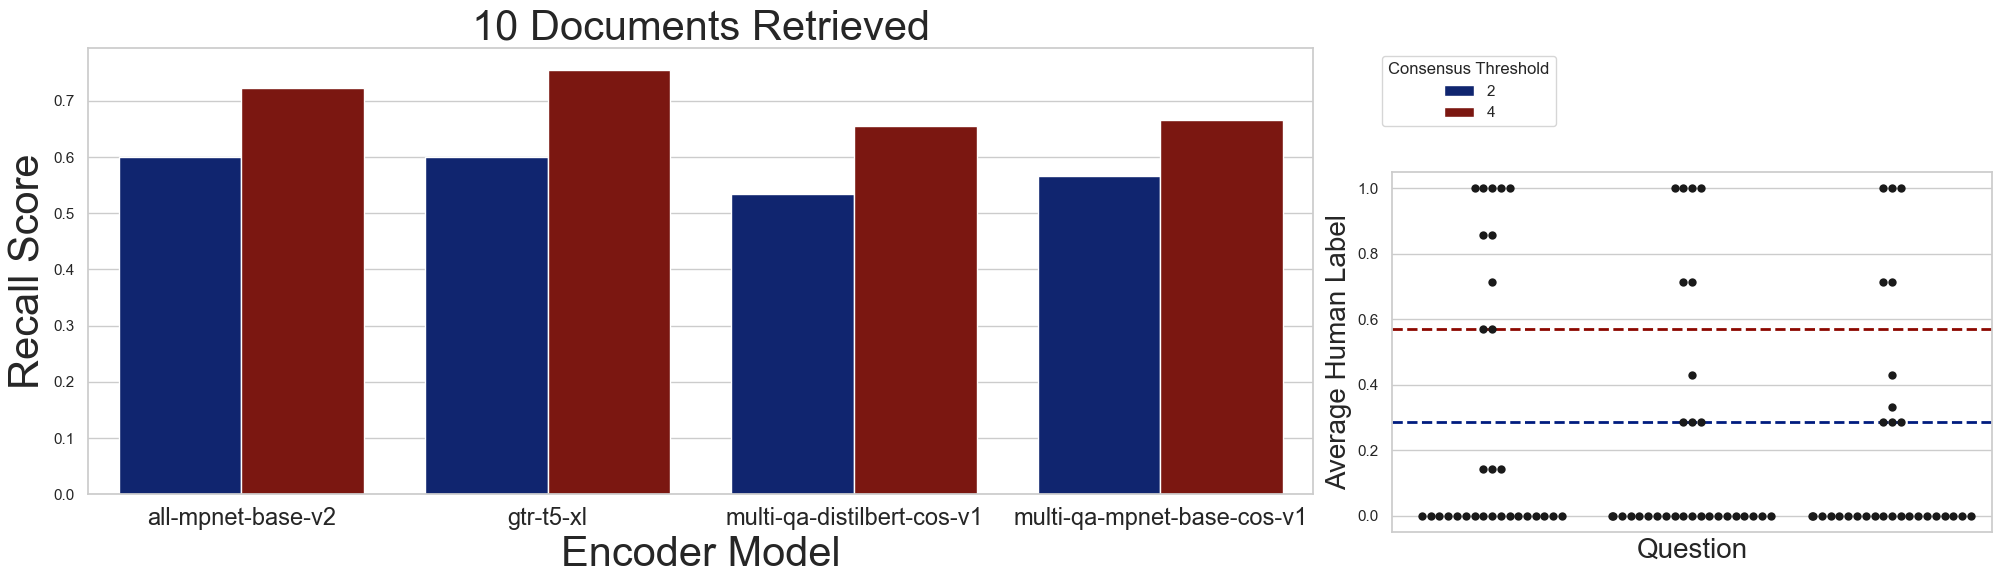

In [211]:
retrieval_size = 10
similarity_metric = 'cosine'
evaluation_metric = 'recall'
plot_performance(retrieval_size, 
        similarity_metric, 
        evaluation_metric, 
        summary_df, 
        df,
        save_path= f'../../figures/embedding-{similarity_metric}_similarity-performance_n_docs_{retrieval_size}.png')

C:\Users\peter\AppData\Local\Temp\ipykernel_27432\3032364700.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


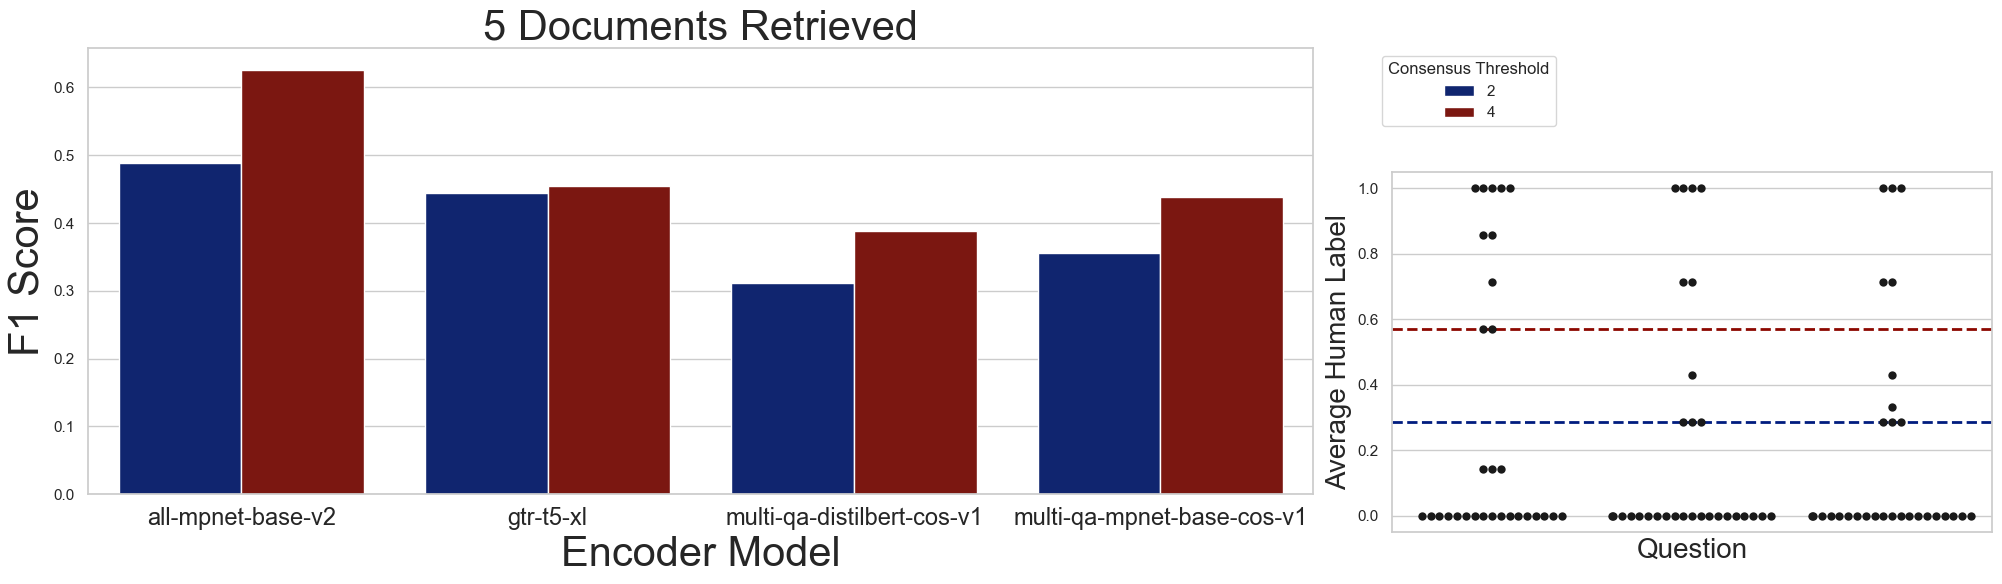

In [208]:
retrieval_size = 5
similarity_metric = 'cosine'
evaluation_metric = 'f1'
plot_performance(retrieval_size, 
        similarity_metric, 
        evaluation_metric, 
        summary_df, 
        df,
        save_path= f'../../figures/embedding-{similarity_metric}_similarity-performance_n_docs_{retrieval_size}.png')